<a href="https://colab.research.google.com/github/MDankloff/Delayed-Fairness-Project/blob/main/BAF_TryOut1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import random
import glob
import os
import joblib


In [2]:
!pip install aequitas #Fairness tree aequitas tool
from aequitas.group import Group # Fairness metrics
from aequitas.bias import Bias
from aequitas.fairness import Fairness

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of aequitas to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 456.4/456.4 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.9/161.9 kB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.8/727.8 kB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 

In [3]:
!pip install mesa pandas scikit-learn networkx
!pip install mesa==1.2.1
from mesa import Model, Agent
from mesa.time import RandomActivation
from collections import defaultdict

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.1 MB/s eta 0:00:00
  Attempting uninstall: mesa
    Found existing installation: Mesa 3.4.0
    Uninstalling Mesa-3.4.0:
      Successfully uninstalled Mesa-3.4.0


# Load BAF data

Saved parquet files from csv

In [4]:
from google.colab import drive
drive.mount('/content/drive')
!cd '/content/drive/MyDrive/Supervision new/Paper#4 Delayed Fairness Project/BAF'

Mounted at /content/drive


In [5]:
base_path = '/content/drive/MyDrive/Supervision new/Paper#4 Delayed Fairness Project/BAF/parquet data'

extension = "parquet" #parquet for smaller files, csv available
data_paths = glob.glob(f"{base_path}/*.{extension}")

def read_dataset(path, ext = extension):
    if ext == "csv":
      return pd.read_csv(path)
    elif ext == "parquet":
      return pd.read_parquet(path)
    else:
      raise ValueError(f"Unsupported file extension: {ext}")

# Extract variant name from the file path (without the extension)
def get_variant(path):
    return os.path.basename(path).split(".")[0]

# Dictionary comprehension to read all CSV files into a dictionary of DataFrames
dataframes = {
    get_variant(path): read_dataset(path) for path in data_paths
}
print(f"Loaded datasets: {list(dataframes.keys())}")

datasets_paths = {
    "Base": base_path + "/Base.parquet", # sampled to best represent original dataset
    "Variant I": base_path + "/Variant I.parquet", # higher group size disparity than base - reducing the size of the minority group from approx 20 - 10% of the dataset
    "Variant II": base_path + "/Variant II.parquet", # higher prevalence disparity than base - one group has 5 x the fraud detection rate of the other while group sizes are equal
    "Variant III": base_path + "/Variant III.parquet", # better separability for one of the groups -
    "Variant IV": base_path + "/Variant IV.parquet", # higher prevalence disparity in train
    "Variant V": base_path + "/Variant V.parquet", # better separability in train for one of the groups
}

Loaded datasets: ['Base', 'Variant I', 'Variant II', 'Variant III', 'Variant IV', 'Variant V']


In [6]:
#Rename datasets
base = dataframes['Base']
variant1 = dataframes['Variant I']
variant2 = dataframes['Variant II']
variant3 = dataframes['Variant III']
variant4 = dataframes['Variant IV']
variant5 = dataframes['Variant V']

#for better display
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

dfs = [base, variant1, variant2, variant3, variant4, variant5]

df4 = variant4 #set to preferred variant
new_df4 = df4.copy()

# Explore Data

In [7]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

In [8]:
#make a simplified df containing only a few features
df4_simple = df4[['fraud_bool', 'customer_age', 'credit_risk_score', 'month']].copy()

In [9]:
df4_simple['month'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7])

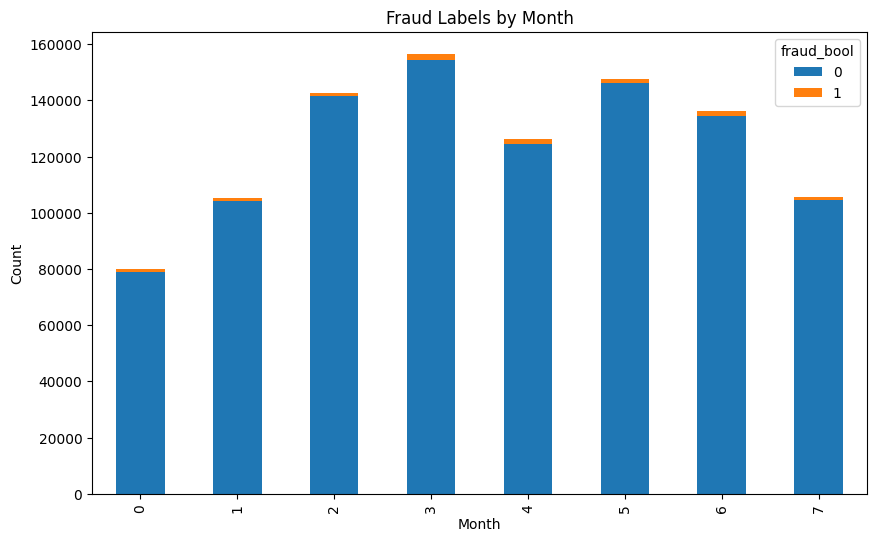

In [10]:
#fraud per month
fraud_per_month = df4_simple.groupby(['month','fraud_bool']).size().unstack()
fraud_per_month.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Fraud Labels by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

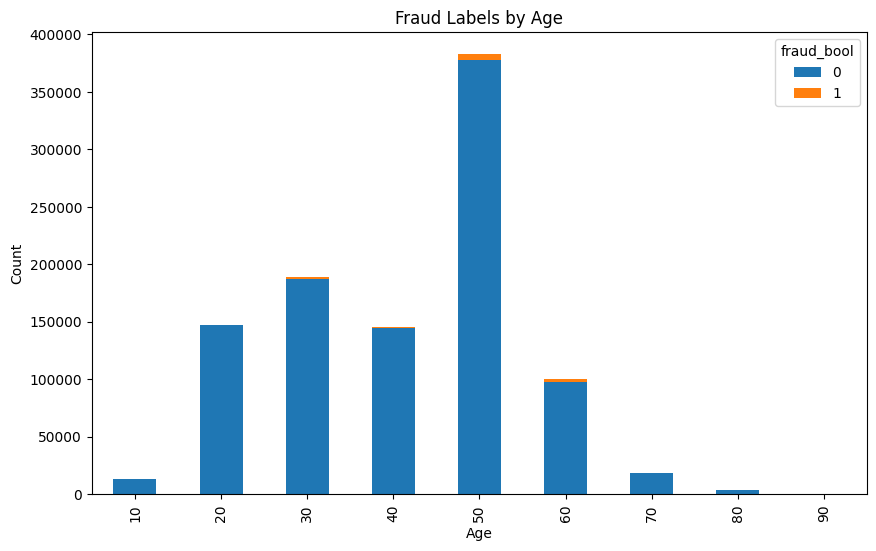

In [11]:
#fraud per age
fraud_per_age = df4_simple.groupby(['customer_age','fraud_bool']).size().unstack()
fraud_per_age.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Fraud Labels by Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

In [12]:
print(df4_simple.iloc[0])

fraud_bool             0
customer_age          30
credit_risk_score    149
month                  0
Name: 0, dtype: int64


# Random Activation

In [13]:
#Randomly order and activate all agents for each simulation step. Could not get mesa.time
'''class RandomActivation:
  def __init__(self, model):
    self.model = model
    self.agents = []

    def add(self, agent):
      self.agents.append(agent)

    def step(self):
      import random
      random.shuffle(self.agents)
      for agent in self.agents:
        agent.step()'''

'class RandomActivation:\n  def __init__(self, model):\n    self.model = model\n    self.agents = []\n\n    def add(self, agent):\n      self.agents.append(agent)\n\n    def step(self):\n      import random\n      random.shuffle(self.agents)\n      for agent in self.agents:\n        agent.step()'

# Create demographic groups

In [14]:
# define age groups - according to BAF authors
df4_simple['group'] = np.where(df4_simple['customer_age'] >= 50, 'Older', 'Younger')

  # split in 2 groups
group_young = df4_simple[df4_simple['group'] == 'Younger']
group_old = df4_simple[df4_simple['group'] == 'Older']

<Axes: xlabel='group'>

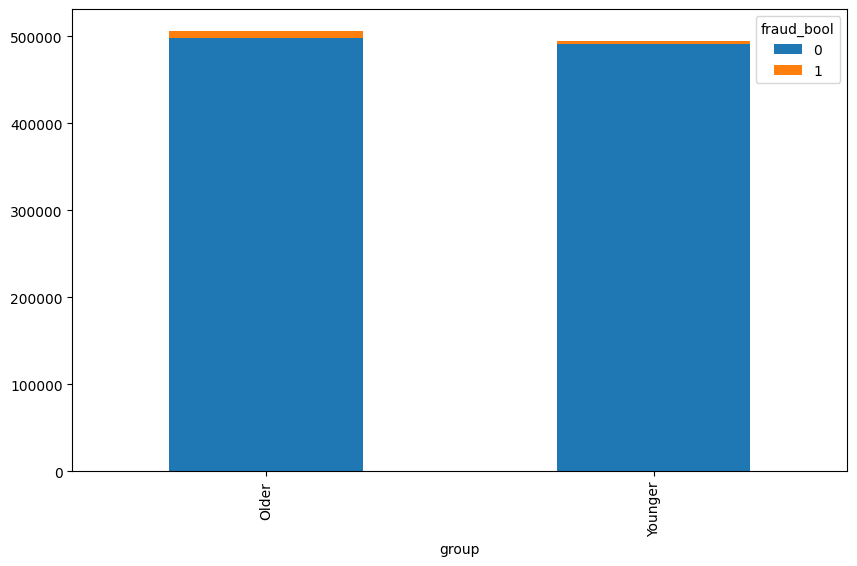

In [15]:
fraud_young_old=df4_simple.groupby(['group','fraud_bool']).size().unstack()
fraud_young_old.plot(kind='bar', stacked=True, figsize=(10, 6))

In [16]:
group_young[group_young['fraud_bool'] == 1]['fraud_bool'].count()

np.int64(2656)

In [17]:
group_old[group_old['fraud_bool'] == 1]['fraud_bool'].count()

np.int64(8374)

# Loan applicant

Decision Di,t=1: applicant is denied (not approved)

Actual Yi,t=1: applicant is fraud

Previous Pi,t=1: applicant was denied last step

Other Oi,t=1: ≥6 of 10 peers denied this step

Unfairness Ui,t=1: decision is perceived as unfair

Opt-out Ai,t=1: applicant does not apply

denial alone is not unfair, correct fraud detection is not unfair


In [49]:
class ApplicantAgent(Agent):
    def __init__(self, unique_id, model, group, credit_risk_score, fraud_label):
        super().__init__(unique_id, model) # Corrected super().__init__() call for mesa.Agent

        # Static attributes
        self.group = group # group_young or group_old
        self.credit_risk_score = credit_risk_score #internal score of application risk
        self.fraud_label = fraud_label #1 = fraud, 0 = no fraud

        # Dynamic states (TL-SCG)
        self.prev_denial = 0 #Pi,t = 1 when applicants were categorized at fraud in previous time step
        self.peer_denial = 0 #Oi,t= 1 when more than 10 peers where denied in current time step --> spillover
        self.perceived_unfairness = 0 #Ui,t =1 when the applicant believes the lending system is unfair (affects willingness to opt in or out) based on spill_over and prev_approval

        #Decision states
        self.applied = True # whether applicant applies for a loan
        self.approved = False # whether they got the loan, updated by lender


#---------------------------------------
#observe 10 random peers from same group
#---------------------------------------
    def peer_spillover(self):
        peers = [
            a for a in self.model.schedule.agents
            if a.group == self.group and a.unique_id != self.unique_id
        ]

        sampled_peers = peers if len(peers) < 10 else random.sample(peers, 10)

        #Denial = not approved
        num_denied = sum(1 for p in sampled_peers if not p.approved)

        #Spillover signal: >= 6 denials
        self.peer_denial = 1 if num_denied >= self.model.fairness_threshold else 0

#------------------------------------------
#perceived fairness update by logical rules
#repeated unjustified denial -> unfair
#peer denial spillover -> unfair
#correct fraud detection alone is NOT unfair
#------------------------------------------

    def update_perceived_unfairness(self):
        '''U{i,t} = 1[(D=1 ∧ P_{t-1}=1 ∧ Y = 0) ∨ (D=1 ∧ O_t=1)]
        decision is perceived as unfair (U) if decision is fraud and past decision is fraud OR if decision is fraud and peer decision is fraud BUT if D=1 and Y=1 then they will opt out
        '''
        decision = 1 if not self.approved else 0  #D_{i_t}
        past = self.prev_denial                   #P_{i,t-1}
        other = self.peer_denial                  #O_{i,t}
        actual = self.fraud_label                 #Y_{i,t}

        self.perceived_unfairness = int((decision == 1 and past == 1 and actual == 0) or (decision == 1 and other == 1)
        )

#Applicant decides each time step whether they apply for a loan. They only apply if the perceived_unfairness is 0

    def step(self):
        #1. observe peers
        self.peer_spillover()

        #2. update perceived fairness
        self.update_perceived_unfairness()

        decision = 1 if not self.approved else 0

        #3. Opt-out rule
        opt_out = (self.perceived_unfairness == 1) or (decision == 1 and self.prev_denial == 1 and self.fraud_label == 1)

        #decision to apply
        self.applied = not opt_out

        #4.store past outcome
        self.prev_denial = decision

        #5. reset approval (updated by lender)
        self.approved = False


# Lender Agent

In [50]:
class LenderAgent(Agent):
  def __init__(self, unique_id, model, fairness_policy= "random", base_prob = 0.5):
    super().__init__(unique_id, model) # Corrected super().__init__() call for mesa.Agent
    self.fairness_policy = fairness_policy
    self.base_prob = base_prob #baseline approval probability for random allocation

    #track group statistics for fairness adjustments
    self.group_stats = defaultdict(lambda: {"approved": 0, "total": 0, "tp": 0, "fp": 0})

  def make_decision(self, applicant):
    group = applicant.group
    score = applicant.credit_risk_score / 300
    y_true = 1 if applicant.fraud_label == 1 else 0

    #base random probability
    prob = self.base_prob

    #apply fairness adjustments

    if self.fairness_policy == "random":
      prob = self.base_prob

    elif self.fairness_policy == "demographic_parity": # Equal selection rates across groups, irrespective of true outcomes
      prob = self.adjust_demographic_parity(group)

    elif self.fairness_policy == "equal_opportunity":  # Equal selection rates for qualified applicants (with true positive outcomes)
      prob = self.adjust_equal_opportunity(group)

    elif self.fairness_policy == "equalized_odds": # Equal true positive and false positive rates across groups
      prob = self.adjust_equalized_odds(group, y_true)

    elif self.fairness_policy == "predictive_parity": #Equal likelihood that a positive prediction is correct (precision) across groups
      prob = self.adjust_predictive_parity(group)

    else:
      raise ValueError(f"Unsupported fairness policy: {self.fairness_policy}")

    decision = random.random() < prob

    # Update group-level stats for next timestep
    self.update_group_stats(group, decision, y_true)

    return decision

# -------------------------------
# Fairness adjustment functions
# -------------------------------
  def adjust_demographic_parity(self, group):
    """
    Adjust approval probability so that selection rates are equal across groups.
    """
    avg_rate = sum(s["approved"]/max(1, s["total"]) for s in self.group_stats.values()) / len(self.group_stats)
    group_rate = self.group_stats[group]["approved"] / max(1, self.group_stats[group]["total"])
    # Increase probability if under-approved, decrease if over-approved
    return max(0.0, min(1.0, self.base_prob + (avg_rate - group_rate)))

  def adjust_equal_opportunity(self, group):
    """
    Adjust approval probability for qualified applicants (Y=1) to equalize TP rates across groups.
    """
    tprates = [s["tp"]/max(1, s["approved"]) for s in self.group_stats.values()]
    avg_tpr = sum(tprates)/len(tprates)
    group_tpr = self.group_stats[group]["tp"]/max(1, self.group_stats[group]["approved"])
    return max(0.0, min(1.0, self.base_prob + (avg_tpr - group_tpr)))

  def adjust_equalized_odds(self, group, y_true):
    """
    Adjust approval probability for all applicants to equalize TP and FP rates.
    """
    s = self.group_stats[group]
    if y_true == 1:
        tp_rate = s["tp"] / max(1, s["approved"])
        avg_tp = sum(gs["tp"]/max(1, gs["approved"]) for gs in self.group_stats.values()) / len(self.group_stats)
        return max(0.0, min(1.0, self.base_prob + (avg_tp - tp_rate)))
    else:
        fp_rate = (s["approved"] - s["tp"]) / max(1, s["approved"])
        avg_fp = sum((gs["approved"]-gs["tp"])/max(1, gs["approved"]) for gs in self.group_stats.values()) / len(self.group_stats)
        return max(0.0, min(1.0, self.base_prob + (avg_fp - fp_rate)))

  def adjust_predictive_parity(self, group):
    """
    Adjust approval probability to equalize PPV (precision) across groups.
    """
    s = self.group_stats[group]
    ppv = s["tp"]/max(1, s["approved"])
    avg_ppv = sum(gs["tp"]/max(1, gs["approved"]) for gs in self.group_stats.values()) / len(self.group_stats)
    return max(0.0, min(1.0, self.base_prob + (avg_ppv - ppv)))

# -------------------------------
# Update group statistics
# -------------------------------
  def update_group_stats(self, group, decision, y_true):
    s = self.group_stats[group]
    s["total"] += 1
    if decision:
        s["approved"] += 1
        if y_true == 1:
            s["tp"] += 1
        else:
            s["fp"] += 1


# Loan model

In [51]:
class LoanModel:
  def __init__(self, df, fairness_policy = "random"):
    super().__init__()
    self.schedule = RandomActivation(self) # Pass 'self' as the model argument
    self.fairness_policy = fairness_policy

    #threshold for spillover 6/10 peers
    self.fairness_threshold = 6 # can change this

    #track group-level perceived fairness
    self.group_fairness = {"Younger": 1.0, "Older": 1.0}

    #time series tracking
    self.history = {
        "Younger": {"applied": [], "approved": [], "opted_out": []},
        "Older": {"applied": [], "approved": [], "opted_out": []},
    }

    #add lender
    self.lender = LenderAgent(unique_id = "lender", model=self, fairness_policy= fairness_policy, base_prob= 0.5)

    #add applicants
    for i, row in df.iterrows():
        agent = ApplicantAgent(
            i,
            self,
            row['group'],
            row['credit_risk_score'],
            row['fraud_bool']
            )
        self.schedule.add(agent)

  def step(self):
      # 1) Applicants decide to apply
      for agent in self.schedule.agents:
          if isinstance(agent, ApplicantAgent):
              agent.step()

      # 2) Lender evaluates applications
      for agent in self.schedule.agents:
          if isinstance(agent, ApplicantAgent) and agent.applied:
              agent.approved = self.lender.make_decision(agent)

      # 3) Update group-level fairness (average approval rate)
      for group in ["Younger", "Older"]:
          agents = [a for a in self.schedule.agents if isinstance(a, ApplicantAgent) and a.group == group]
          if agents:
              self.group_fairness[group] = np.mean([a.approved for a in agents])

      # 4) Record timestep statistics
      for group in ["Younger", "Older"]:
          agents = [a for a in self.schedule.agents if isinstance(a, ApplicantAgent) and a.group == group]
          applied = sum(a.applied for a in agents)
          approved = sum(a.approved for a in agents)
          opted_out = sum(not a.applied for a in agents)
          self.history[group]["applied"].append(applied)
          self.history[group]["approved"].append(approved)
          self.history[group]["opted_out"].append(opted_out)

  def plot_group_dynamics(self):
        """Plot applications, approvals, and opt-outs over time for each group."""
        for group in ["Younger", "Older"]:
            history = self.history[group]
            timesteps = range(len(history["applied"]))

            plt.figure(figsize=(10, 5))
            plt.plot(timesteps, history["applied"], label="Applied", marker='o')
            plt.plot(timesteps, history["approved"], label="Approved", marker='o')
            plt.plot(timesteps, history["opted_out"], label="Opted Out", marker='o')
            plt.title(f"Group dynamics over time: {group}")
            plt.xlabel("Time step")
            plt.ylabel("Number of applicants")
            plt.legend()
            plt.grid(True)
            plt.show()

  def plot_group_fairness(self):
        """Plot the evolving average approval rate (group fairness) over time."""
        for group in ["Younger", "Older"]:
            approvals = self.history[group]["approved"]
            applied = self.history[group]["applied"]
            timesteps = range(len(approvals))
            # Avoid division by zero
            avg_approval_rate = [a / max(1, ap) for a, ap in zip(approvals, applied)]

            plt.figure(figsize=(10, 5))
            plt.plot(timesteps, avg_approval_rate, label="Average Approval Rate", marker='o')
            plt.title(f"Average approval rate over time: {group}")
            plt.xlabel("Time step")
            plt.ylabel("Approval rate")
            plt.ylim(0, 1)
            plt.grid(True)
            plt.legend()
            plt.show()

# Simulate

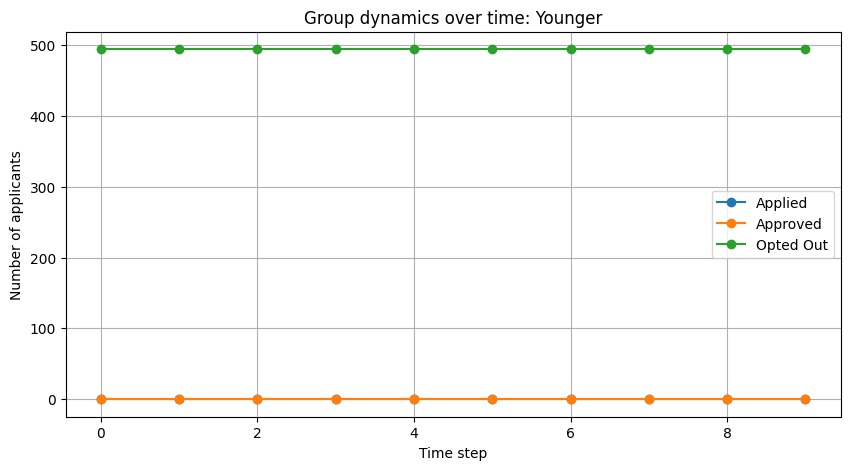

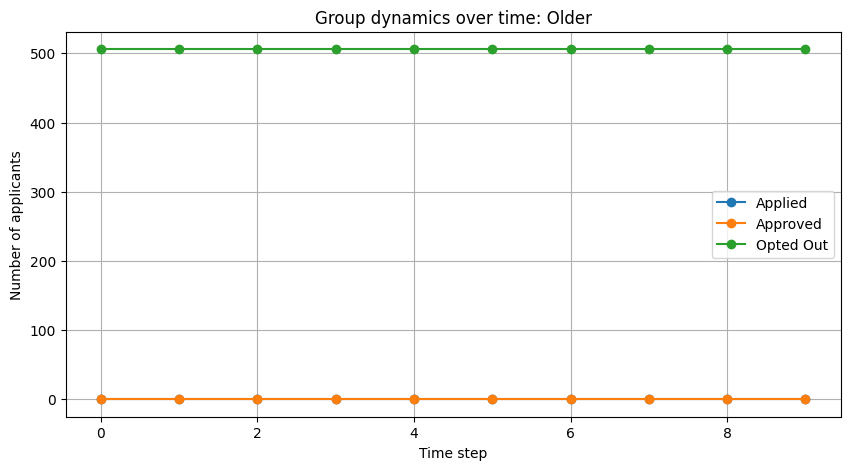

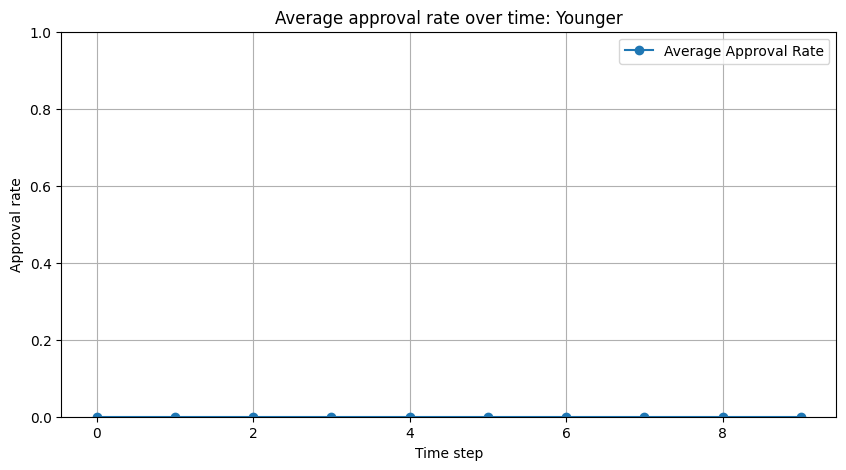

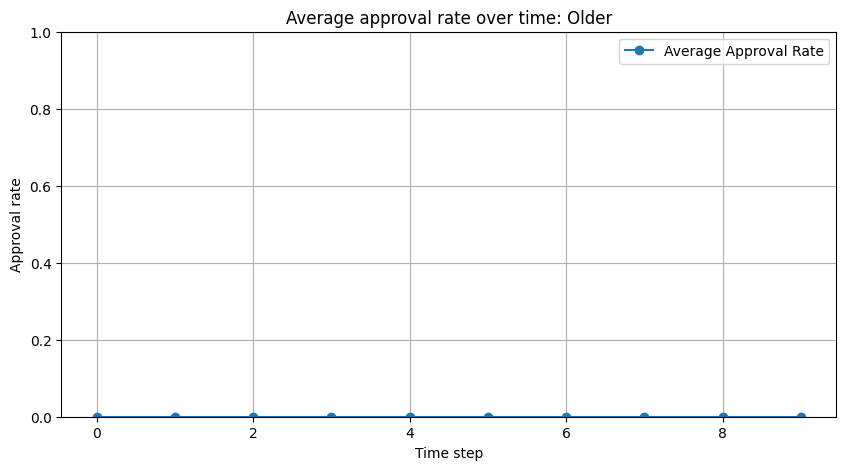

In [52]:
# Initialize model
model = LoanModel(df4_simple.sample(n=1000), fairness_policy="random")

# Run simulation for 10 timesteps
for t in range(10):
    model.step()

# Plot number of applications, approvals, opt-outs
model.plot_group_dynamics()

# Plot average approval rate (group fairness)
model.plot_group_fairness()

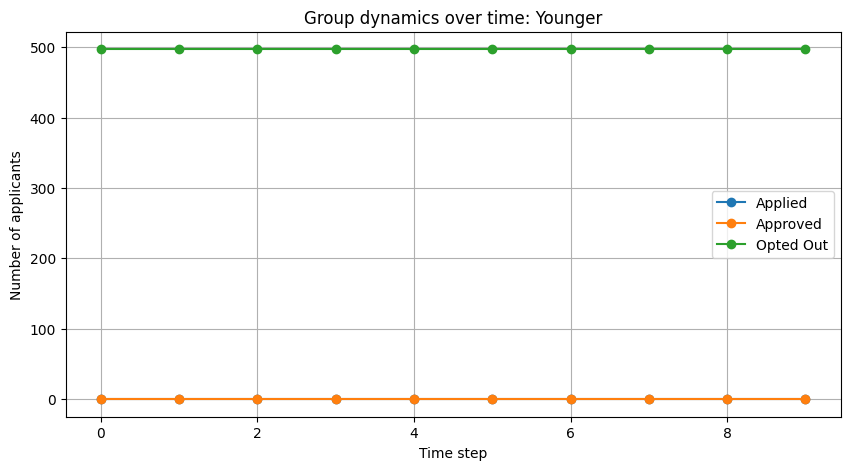

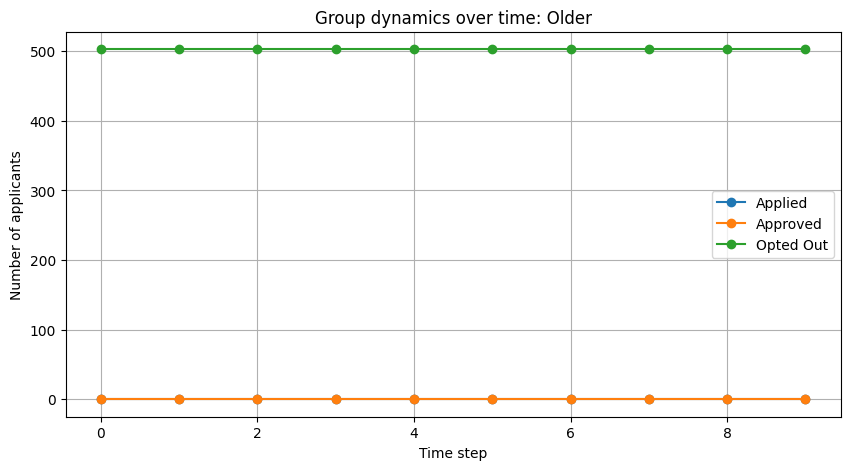

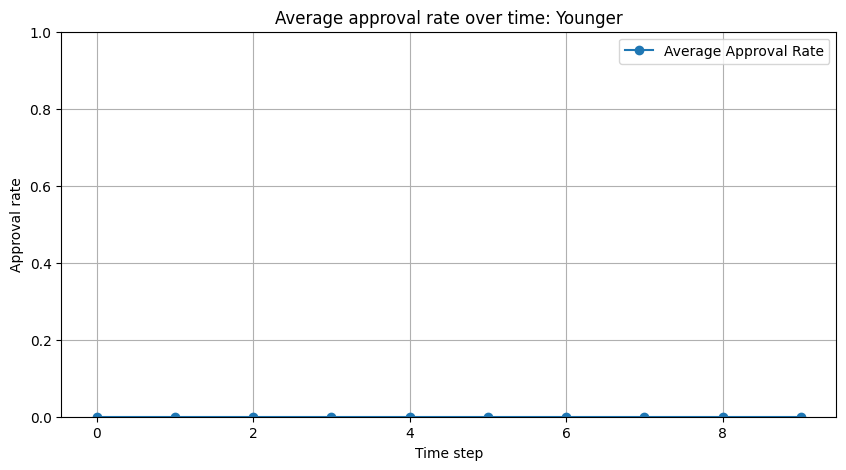

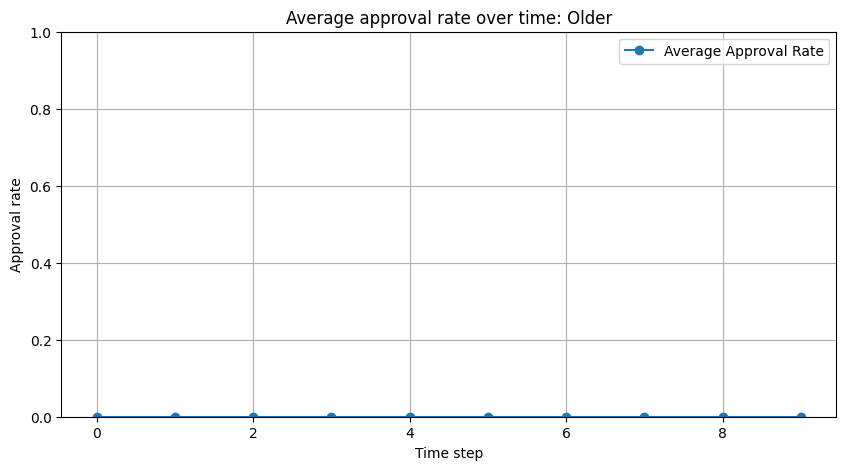

In [53]:
# Initialize model
model = LoanModel(df4_simple.sample(n=1000), fairness_policy="random")

# Run simulation for 10 timesteps
for t in range(10):
    model.step()

# Plot number of applications, approvals, opt-outs
model.plot_group_dynamics()

# Plot average approval rate (group fairness)
model.plot_group_fairness()